In [12]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os

In [13]:
# Load CSV with image paths and labels
df = pd.read_csv("labels.csv")

# Stratified split (70% training, 20% validation, 10% testing)
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.333, stratify=temp_df["label"], random_state=42
)

# Save splits to CSV files
train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

In [14]:
# Cell 3: Preprocessing Functions (FIXED)
def apply_clahe(img):
    """Apply CLAHE contrast enhancement using OpenCV"""
    img = (img.numpy() * 255).astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB).astype(np.float32) / 255.0

def load_process_image(path, label):
    """Load and preprocess image with aspect ratio preservation (FIXED LABEL CASTING)"""
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize_with_pad(img, 224, 224, antialias=True)
    img = img / 255.0
    img = tf.image.rgb_to_yuv(img)
    img = (img - tf.reduce_mean(img)) / tf.math.reduce_std(img)
    return img, tf.cast(label, tf.int32)  # FIX: Cast label to int32

def safe_crop(img):
    """Ensure central retina region is preserved"""
    cropped = tf.image.random_crop(img, [200, 200, 3])
    return tf.cond(
        tf.reduce_all(tf.equal(cropped[80:120, 80:120], img[80:120, 80:120])),
        lambda: cropped,
        lambda: tf.image.central_crop(img, 200/224)
    )

In [15]:
# Cell 4: Initialize Augmentation Layers (NEW FIX)
# Define augmentation layers outside the function to prevent recreation
random_rot = tf.keras.layers.RandomRotation(0.1)
gaussian_noise = tf.keras.layers.GaussianNoise(0.001)

In [16]:
# Cell 5: Augmentation Function (FIXED)
def augment_image(img, label):
    """Enhanced augmentation pipeline for retinal images (FIXED LAYER USAGE)"""
    # Geometric transforms
    img = tf.image.random_flip_left_right(img)
    img = random_rot(img)  # Use pre-initialized layer
    
    # Color transforms
    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_hue(img, 0.05)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.adjust_gamma(img, gamma=tf.random.uniform([], 0.8, 1.2))
    
    # Noise and artifacts
    img = gaussian_noise(img)  # Use pre-initialized layer
    if tf.random.uniform(()) > 0.5:
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=0.02)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 1.0)
    
    # CLAHE enhancement
    img, label = tf.py_function(
        func=lambda x,y: (apply_clahe(x), y),
        inp=[img, label],
        Tout=(tf.float32, tf.int32)
    )
    img.set_shape([224, 224, 3])
    
    # Safe cropping
    img = safe_crop(img)
    img = tf.image.resize(img, [224, 224])
    
    return img, label

In [17]:
# Cell 6: Dataset Creation (FIXED)
def create_dataset(df, batch_size=32, augment=False):
    """Create optimized TensorFlow dataset with class balancing"""
    # Convert labels to int32 before creating dataset
    ds = tf.data.Dataset.from_tensor_slices(
        (df["image_path"], df["label"].astype(np.int32))
    )
    ds = ds.map(load_process_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augment:
        ds = ds.concatenate(ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE))
        ds = ds.concatenate(ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE))
        ds = ds.shuffle(1000)
    else:
        ds = ds.cache()
        
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
# Cell 7: Initialize Layers with Dummy Data (NEW FIX)
# Initialize layers before dataset creation
dummy_img = tf.zeros([1, 224, 224, 3])
_ = random_rot(dummy_img)
_ = gaussian_noise(dummy_img)

# Create datasets
train_ds = create_dataset(train_df, augment=True)
val_ds = create_dataset(val_df)
test_ds = create_dataset(test_df)

In [19]:
def visualize_clahe_effect(image_path):
    """Compare original vs CLAHE-enhanced image"""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize_with_pad(img, 224, 224)
    img_norm = img / 255.0
    
    # Apply CLAHE
    img_clahe = apply_clahe(img_norm)
    
    # Plot comparison
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_norm.numpy())
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img_clahe)
    plt.title("CLAHE Enhanced")
    plt.axis('off')
    plt.show()

In [20]:
def visualize_augmentations(dataset, n=3):
    """Visualize original + augmented images side by side"""
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        for i in range(n):
            # Original image
            ax = plt.subplot(2, n, i+1)
            plt.imshow(images[i].numpy())
            plt.title(f"Original\nLabel: {labels[i].numpy()}")
            plt.axis("off")
            
            # Augmented image
            aug_img, _ = augment_image(images[i], labels[i])
            ax = plt.subplot(2, n, n+i+1)
            plt.imshow(aug_img.numpy())
            plt.title(f"Augmented\nLabel: {labels[i].numpy()}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

In [21]:
def plot_class_distribution(df, title):
    """Enhanced class distribution plot with percentages"""
    counts = df["label"].value_counts().sort_index()
    total = counts.sum()
    
    plt.bar(counts.index, counts.values)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    
    # Add percentage annotations
    for i, count in enumerate(counts):
        percent = count/total*100
        plt.text(i, count+5, f"{percent:.1f}%", ha='center')

In [22]:
def visualize_dataset_samples(datasets, titles):
    """Visualize samples from different dataset splits"""
    plt.figure(figsize=(15, 5))
    for idx, (dataset, title) in enumerate(zip(datasets, titles)):
        for images, labels in dataset.take(1):
            plt.subplot(1, 3, idx+1)
            plt.imshow(images[0].numpy())
            plt.title(f"{title}\nLabel: {labels[0].numpy()}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

In [23]:
def visualize_tta(image, augmented_images):
    """Visualize Test-Time Augmentations"""
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 4, 1)
    plt.imshow(image.numpy())
    plt.title("Original")
    plt.axis("off")
    
    for i, aug_img in enumerate(augmented_images):
        plt.subplot(1, 4, i+2)
        plt.imshow(aug_img.numpy())
        plt.title(f"TTA {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [29]:
def tta_wrap(image, label):
    """Create multiple augmented versions for testing"""
    return tf.stack([
        image,
        tf.image.flip_left_right(image),
        tf.image.rot90(image),
    ]), tf.stack([label]*3)

CLAHE Enhancement Comparison:


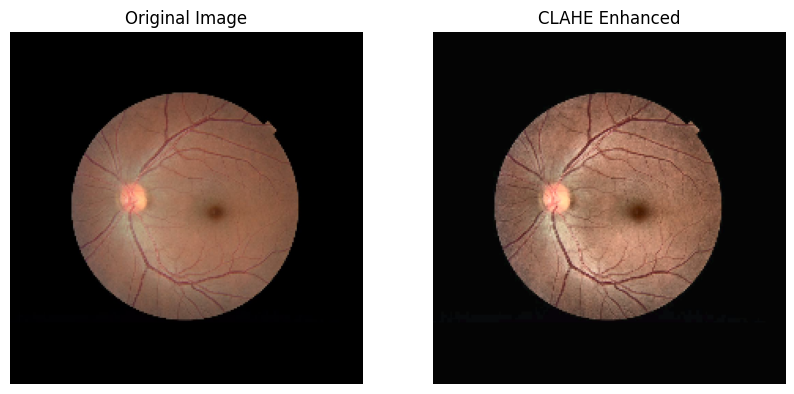

In [24]:
# Visualize CLAHE effect
print("CLAHE Enhancement Comparison:")
visualize_clahe_effect(train_df["image_path"].iloc[0])


Augmentation Examples:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8017188..5.3273025].
C:\Users\utkarsh\AppData\Local\Temp\ipykernel_9372\132593523.py:4: RuntimeWarning: invalid value encountered in cast
  img = (img.numpy() * 255).astype(np.uint8)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2811255..5.530285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5767409..3.4407604].


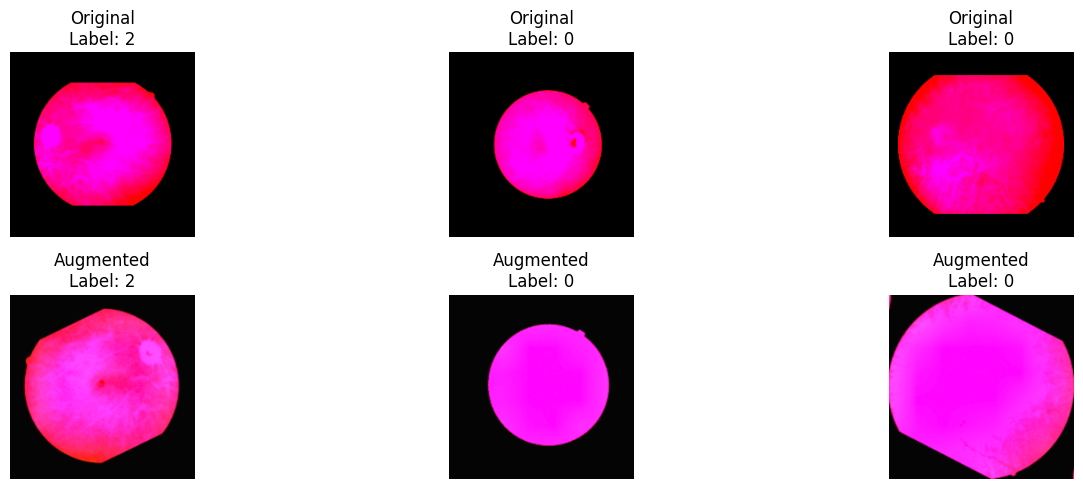

In [25]:
# Visualize Augmentations
print("\nAugmentation Examples:")
visualize_augmentations(train_ds, n=3)


Class Distributions:


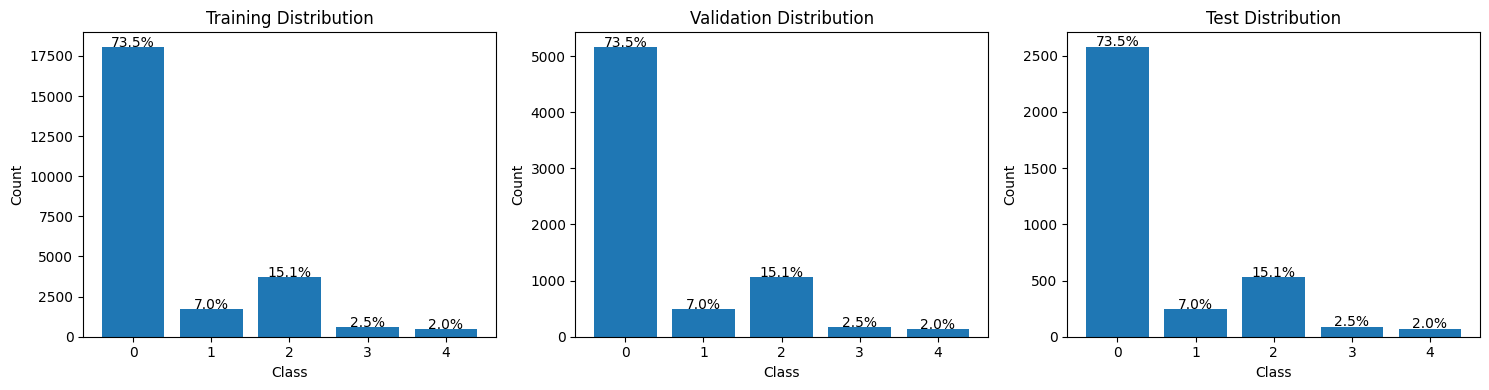

In [26]:
# Class Distribution Visualization
print("\nClass Distributions:")
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_class_distribution(train_df, "Training Distribution")
plt.subplot(1, 3, 2)
plot_class_distribution(val_df, "Validation Distribution")
plt.subplot(1, 3, 3)
plot_class_distribution(test_df, "Test Distribution")
plt.tight_layout()
plt.show()


Dataset Samples:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.558208..6.8290977].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0099792..3.372539].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5442376..4.7568884].


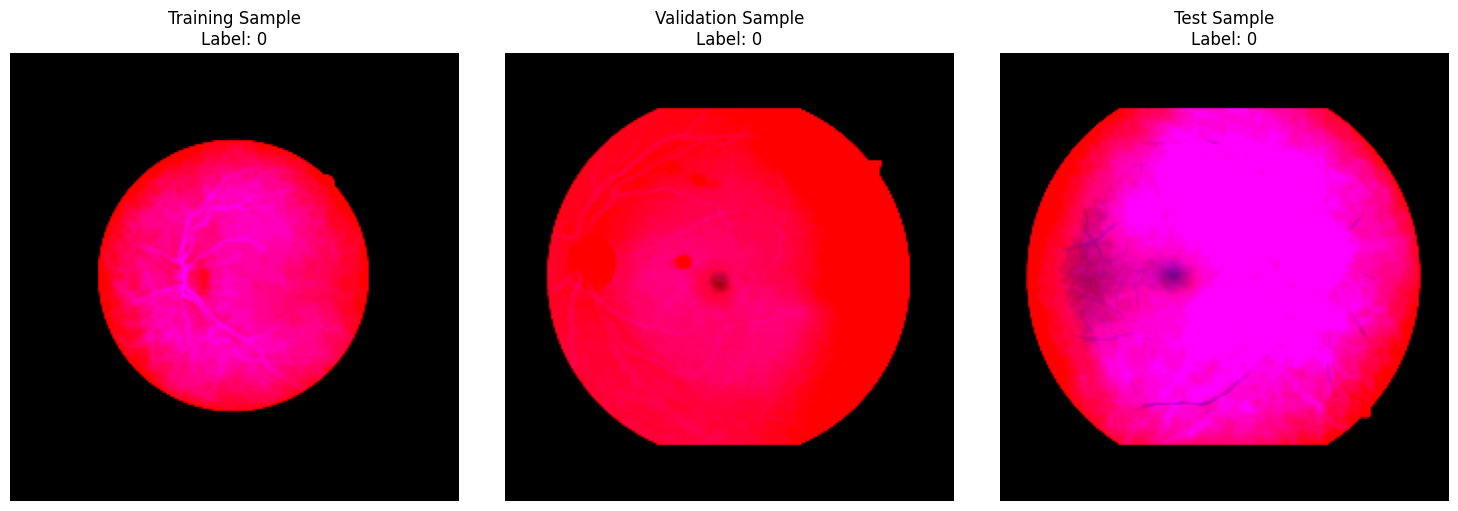

In [27]:
# Dataset Samples Visualization
print("\nDataset Samples:")
visualize_dataset_samples(
    [train_ds, val_ds, test_ds],
    ["Training Sample", "Validation Sample", "Test Sample"]
)


Test-Time Augmentations:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5442376..4.7568884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5442376..4.7568884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5442376..4.7568884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5442376..4.7568884].


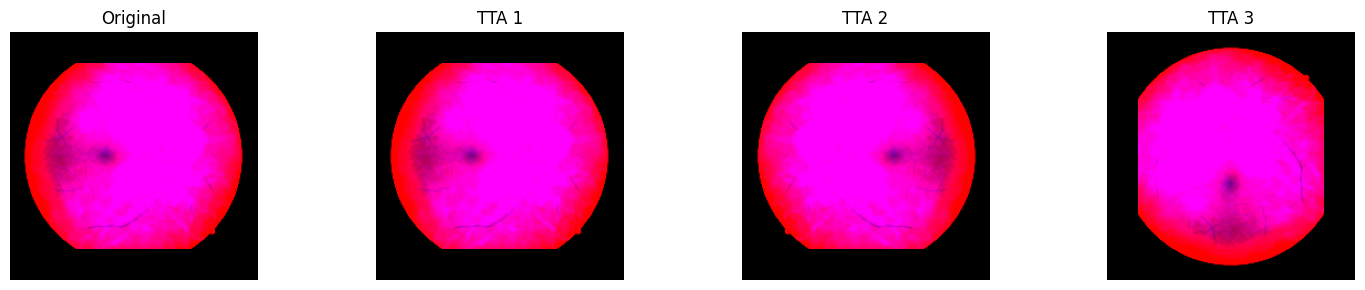

In [30]:
print("\nTest-Time Augmentations:")
test_image, test_label = next(iter(test_ds.unbatch().take(1)))
augmented_images, _ = tta_wrap(test_image, test_label)
visualize_tta(test_image, augmented_images)
